In [1]:
import numpy as np
import matplotlib.pyplot as plt
import koopman as koop
from scipy import stats
from scipy.integrate import quad 


# Rotation on a circle

The stochastic equation is: $x_{t +1} = x_t + \nu + \omega t$
where $\nu$ is a fixed rotation angle and $\omega_t\sim Uniform[-0.5, 0.5]$. The function below generates a trajectory for number of time steps T, with rotation angle $\nu$ and initial condition $x_0$.

In [2]:
def circle_rotation(x0, T, nu):
    solution  = np.zeros(T)
    solution[0] = x0
    for i in range(1, T):
        # draw random number
        omega = np.random.rand() - 0.5
        # update
        solution[i] =np.mod(solution[i - 1] + nu + omega, 2*np.pi)
    return solution

Start by plotting a trajectory

Text(0.5, 1.0, 'Circle rotations for  100 time steps')

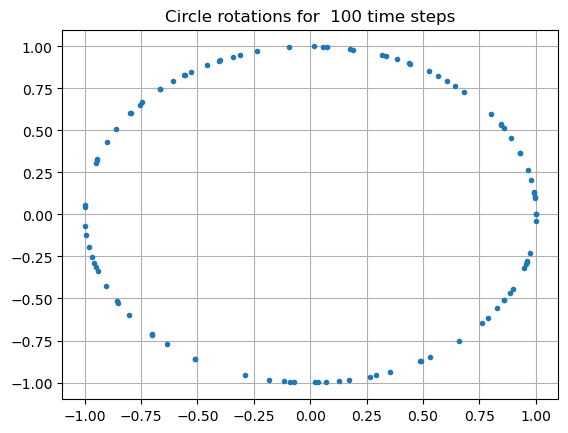

In [3]:
T = 100
rotation = circle_rotation(0, T, 0.5)
plt.plot(np.cos(rotation), np.sin(rotation), '.')
plt.grid()
plt.title('Circle rotations for  %i time steps' % T)

## L2 case
We start with Fourier basis functions made of sine and cosine up to order 5. Then the number of basis vectors is N = 10. The measures are $\sin{ix}dx, \cos{ix}dx$ for $i = 1,\dots,  5$. We sample K = 100 points from each measure and evolve them forward for T = 10 time steps. The data matrix is composed of the location of these $K*N$ points at time T.

First, we implemet a rejection sampling method for obtaining samples from $g_i$. We use the uniform distribution as the proposal.

In [4]:
def rejection_sample(pdf):
    while True:
        u = np.random.uniform()
        y = np.random.uniform()
        if u < pdf(y):
            return y
        

Set the hyperparameters

In [5]:
K = 100
N = 10
T = 10
nu = 0.5

Generate the data matrix by:
- sampling K points out of each of the N distributions
- propagate the points through the dynamics for time T
- record their location in the data matrix

Here we use indicators as the distributions. We split the interval $[0, 2\pi]$ in N parts, and sample uniformly on each part. 

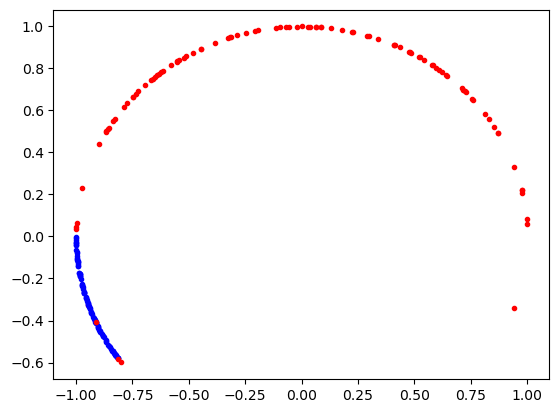

In [6]:
data = np.zeros((K, N))
for i in range(N):
    # define the distributions to sample from if not uniform
    #f = lambda x:(i%2)*np.sin((i + 1)/2*x) - (i%2 - 1)*np.cos((i + 2)/2*x)
    for k in range(K):
        #x0 = rejection_sample(f)
        x0 = i* 2 * np.pi / N +  2 * np.pi / N * np.random.uniform()
        xT = circle_rotation(x0, T, nu)
        
        # plot the samples and their images under the dynamics for specific measure 
        if i == 5:
            plt.plot(np.cos(x0), np.sin(x0), 'b.')
            plt.plot(np.cos(xT[-1]), np.sin(xT[-1]), 'r.')
        data[k, i] = xT[-1]

Initiate the koopman object with N = 10 basis functions of type 'fourier'. 

In [7]:
K_circle = koop.koopman(10, 'indicators')
K_circle.L2_dmd(data)

100
[[0.02 0.07 0.25 0.2  0.2  0.11 0.04 0.   0.   0.02]
 [0.   0.05 0.1  0.25 0.32 0.24 0.1  0.06 0.01 0.  ]
 [0.   0.02 0.02 0.12 0.23 0.22 0.25 0.05 0.03 0.  ]
 [0.   0.   0.   0.06 0.11 0.27 0.27 0.16 0.07 0.02]
 [0.03 0.   0.   0.   0.03 0.11 0.22 0.38 0.22 0.13]
 [0.09 0.01 0.01 0.   0.   0.03 0.08 0.17 0.31 0.2 ]
 [0.23 0.14 0.02 0.   0.   0.01 0.03 0.14 0.16 0.22]
 [0.35 0.17 0.06 0.03 0.   0.   0.   0.04 0.12 0.27]
 [0.2  0.32 0.17 0.11 0.03 0.   0.   0.   0.07 0.11]
 [0.08 0.22 0.37 0.23 0.08 0.01 0.01 0.   0.01 0.03]]


Find the egenvalues and eigenvectors and plot the corresponding eigenfunctions of the koopman operator. The true values are $$\phi_n(x) = e^{inx}$$ with eigenvalues $$\lambda_n = \mathbb{E}[e^{in(\nu + \omega_t)}]$$


In [8]:
evals, evects = np.linalg.eig(K_circle.mat)
evects = np.real(evects)

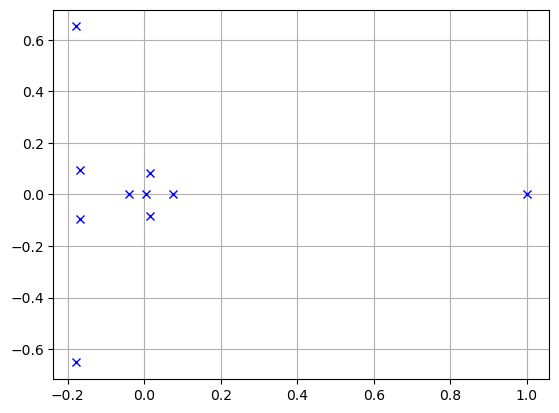

In [9]:
plt.plot(np.real(evals), np.imag(evals), 'bx', label = "computed")
plt.grid()

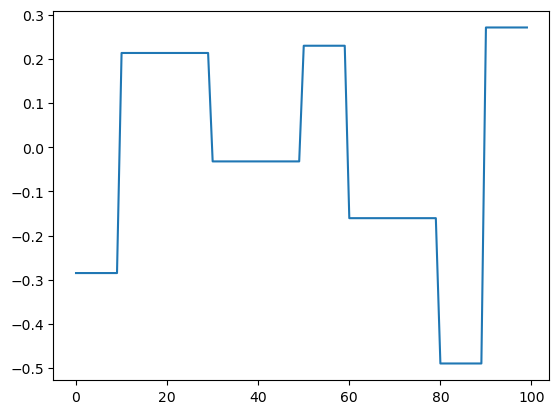

In [13]:
plt.plot(np.repeat(evects[0, :], 10))

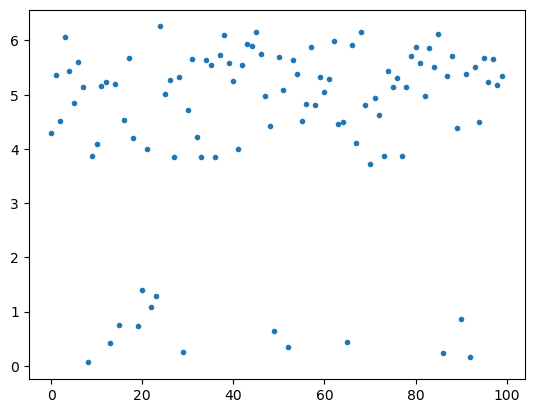

In [11]:
plt.plot(data[:, 1], '.')

In [12]:
K_circle.mat

array([[0.02, 0.07, 0.25, 0.2 , 0.2 , 0.11, 0.04, 0.  , 0.  , 0.02],
       [0.  , 0.05, 0.1 , 0.25, 0.32, 0.24, 0.1 , 0.06, 0.01, 0.  ],
       [0.  , 0.02, 0.02, 0.12, 0.23, 0.22, 0.25, 0.05, 0.03, 0.  ],
       [0.  , 0.  , 0.  , 0.06, 0.11, 0.27, 0.27, 0.16, 0.07, 0.02],
       [0.03, 0.  , 0.  , 0.  , 0.03, 0.11, 0.22, 0.38, 0.22, 0.13],
       [0.09, 0.01, 0.01, 0.  , 0.  , 0.03, 0.08, 0.17, 0.31, 0.2 ],
       [0.23, 0.14, 0.02, 0.  , 0.  , 0.01, 0.03, 0.14, 0.16, 0.22],
       [0.35, 0.17, 0.06, 0.03, 0.  , 0.  , 0.  , 0.04, 0.12, 0.27],
       [0.2 , 0.32, 0.17, 0.11, 0.03, 0.  , 0.  , 0.  , 0.07, 0.11],
       [0.08, 0.22, 0.37, 0.23, 0.08, 0.01, 0.01, 0.  , 0.01, 0.03]])